In [1]:
#%% Initial imports etc
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pSTIR as pet

from sirf.Utilities import examples_data_path
from ccpi.optimisation.algorithms import CGLS, PDHG, FISTA
from ccpi.optimisation.operators import BlockOperator, LinearOperator
from ccpi.optimisation.functions import KullbackLeibler, IndicatorBox, \
         FunctionOperatorComposition, BlockFunction, MixedL21Norm , ZeroFunction, KullbackLeibler
from ccpi.framework import ImageData
from ccpi.plugins.regularisers import FGP_TV#, FGP_dTV
setattr(FGP_TV, 'convex_conjugate', lambda self,x: 0.0)

%matplotlib inline

try:
    import numba
    from numba import jit, prange
    import numpy
    from numpy import sqrt, log, inf
    has_numba = True
    '''Some parallelisation of KL calls'''
    @jit(nopython=True)
    def kl_proximal(x,b, bnoise, tau, out):
            for i in prange(x.size):
                out.flat[i] = 0.5 *  ( 
                    ( x.flat[i] - bnoise.flat[i] - tau ) +\
                    numpy.sqrt( (x.flat[i] + bnoise.flat[i] - tau)**2. + \
                        (4. * tau * b.flat[i]) 
                    )
                )
    @jit(nopython=True)
    def kl_proximal_conjugate(x, b, bnoise, tau, out):
        #z = x + tau * self.bnoise
        #return 0.5*((z + 1) - ((z-1)**2 + 4 * tau * self.b).sqrt())

        for i in prange(x.size):
            z = x.flat[i] + ( tau * bnoise.flat[i] )
            out.flat[i] = 0.5 * ( 
                (z + 1) - numpy.sqrt((z-1)*(z-1) + 4 * tau * b.flat[i])
                )
    @jit(nopython=True)
    def kl_gradient(x, b, bnoise, out):
        for i in prange(x.size):
            out.flat[i] = 1 - b.flat[i]/(x.flat[i] + bnoise.flat[i])

    @jit(nopython=True)
    def kl_div(x, y, out):
        for i in prange(x.size):
            X = x.flat[i]
            Y = y.flat[i]    
            if x.flat[i] > 0 and y.flat[i] > 0:
                out.flat[i] = X * numpy.log(X/Y) - X + Y
            elif X == 0 and Y >= 0:
                out.flat[i] = Y
            else:
                out.flat[i] = numpy.inf
    
    # force a jit
    x = numpy.asarray(numpy.random.random((10,10)), dtype=numpy.float32)
    b = numpy.asarray(numpy.random.random((10,10)), dtype=numpy.float32)
    bnoise = numpy.zeros_like(x)
    out = numpy.empty_like(x)
    tau = 1.
    kl_div(b,x,out)
    kl_gradient(x,b,bnoise,out)
    kl_proximal(x,b, bnoise, tau, out)
    kl_proximal_conjugate(x,b, bnoise, tau, out)

except ImportError as ie:
    has_numba = False

class ChangeSign(object):
    def __init__(self):
        pass
    
    @staticmethod
    def get_instance(class_name, *args,**kwargs):
        
        setattr(class_name, '__call__', ChangeSign.KL_call)
        setattr(class_name, 'gradient', ChangeSign.KL_gradient)
        setattr(class_name, 'proximal_conjugate', ChangeSign.KL_proximal_conjugate)
        
        instance = class_name(*args, **kwargs)
        return instance

    ### Few fixes for common interface
    @staticmethod
    def KL_call(self, x):
        return - self.get_value(x)
    @staticmethod
    def KL_gradient(self, image, subset = -1, out = None):

        assert_validity(image, pet.ImageData)
        grad = pet.ImageData()
        grad.handle = pystir.cSTIR_objectiveFunctionGradient\
            (self.handle, image.handle, subset)
        check_status(grad.handle)
        # change sign
        #grad*=-1
        if out is None:
            return -1 * grad  
        else:
            out.fill(-1 * grad)
    @staticmethod
    def KL_proximal_conjugate(self, x, tau, out=None):

        r'''Proximal operator of the convex conjugate of KullbackLeibler at x:

           .. math::     prox_{\tau * f^{*}}(x)
        '''
        
        self.bnoise = x * 0.
        if has_numba:
            if out is None:
                out = (x * 0.)
                out_np = out.as_array()
                kl_proximal_conjugate(x.as_array(), self.b.as_array(), self.bnoise.as_array(), tau, out_np)
                out.fill(out_np)
                return out
            else:
                out_np = out.as_array()
                kl_proximal_conjugate(x.as_array(), self.b.as_array(), self.bnoise.as_array(), tau, out_np)
                out.fill(out_np)                    
        else:
            if out is None:
                z = x + tau * self.bnoise
                return 0.5*((z + 1) - ((z-1)**2 + 4 * tau * self.b).sqrt())
            else:
                
                tmp = tau * self.bnoise
                tmp += x
                tmp -= 1
                
                self.b.multiply(4*tau, out=out)    
                
                out.add(tmp.power(2), out=out)
                out.sqrt(out=out)
                out *= -1
                tmp += 2
                out += tmp
                out *= 0.5

In [2]:
# Define norm for the acquisition model
def norm(self, **kwargs):
    return LinearOperator.PowerMethod(self, kwargs.get('iterations',10))[0]

setattr(pet.AcquisitionModelUsingRayTracingMatrix, 'norm', norm)

    



#% go to directory with input files

EXAMPLE = 'SIMULATION'


if EXAMPLE == 'SIMULATION':
    
    # adapt this path to your situation (or start everything in the relevant directory)
    os.chdir('/mnt/data/CCPPETMR/201909_hackathon/Simulations/PET/SimulationData')
    ##%% copy files to working folder and change directory to where the output files are
    new_dir = 'exhale-output-CIL-numba'
    
    #shutil.rmtree(new_dir,True)
    #shutil.copytree('Exhale',new_dir)
    os.chdir(new_dir)
    
    attenuation_header = 'pet_dyn_4D_resp_simul_dynamic_0_state_0_attenuation_map.hv'
    image_header = attenuation_header
    sinogram_header = 'pet_dyn_4D_resp_simul_dynamic_0_state_0.hs'

elif EXAMPLE == 'SMALL':
    # adapt this path to your situation (or start everything in the relevant directory)
    os.chdir(examples_data_path('PET'))
    #
    ##%% copy files to working folder and change directory to where the output files are
    shutil.rmtree('working_folder/thorax_single_slice',True)
    shutil.copytree('thorax_single_slice','working_folder/thorax_single_slice')
    os.chdir('working_folder/thorax_single_slice')
    
    image_header = 'emission.hv'
    attenuation_header = 'attenuation.hv'
    sinogram_header = 'template_sinogram.hs'

    
elif EXAMPLE == 'BRAIN':
    # adapt this path to your situation (or start everything in the relevant directory)
    os.chdir(examples_data_path('PET'))
    #
    ##%% copy files to working folder and change directory to where the output files are
    shutil.rmtree('working_folder/brain',True)
    shutil.copytree('brain','working_folder/brain')
    os.chdir('working_folder/brain')
    
    image_header = 'emission.hv'
    attenuation_header = 'attenuation.hv'
    sinogram_header = 'template_sinogram.hs'

# Read in images
    
image = pet.ImageData(image_header);
image_array=image.as_array()
mu_map = pet.ImageData(attenuation_header);
mu_map_array=mu_map.as_array();

# Show Emission image
print('Size of emission: {}'.format(image.shape))

# plt.imshow(image.as_array()[0])
# plt.colorbar()
# plt.title('Emission')
# #plt.show()

# plt.imshow(mu_map.as_array()[0])
# plt.colorbar()
# plt.title('Attenuation')
#plt.show()

#%%

am = pet.AcquisitionModelUsingRayTracingMatrix()
# we will increate the number of rays used for every Line-of-Response (LOR) as an example
# (it is not required for the exercise of course)
am.set_num_tangential_LORs(5)
templ = pet.AcquisitionData(sinogram_header)
# this seems to use a lot of memory! 256 Gb went!
# pet.AcquisitionData.set_storage_scheme('memory')
am.set_up(templ,image)

#% simulate some data using forward projection
if EXAMPLE == 'SIMULATION':
    
    acquired_data = templ
    image.fill(1)
    noisy_data = acquired_data.clone()

elif EXAMPLE in ['SMALL', 'BRAIN']:
    
    acquired_data=am.forward(image)
    
    acquisition_array = acquired_data.as_array()

    np.random.seed(10)
    noisy_data = acquired_data.clone()
    scale = 100
    noisy_array = scale * np.random.poisson(acquisition_array/scale).astype('float64')
    print(' Maximum counts in the data: %d' % noisy_array.max())
    noisy_data.fill(noisy_array)



#%% Display bitmaps of a middle sinogram
    
#     plt.imshow(noisy_array[0,0,:,:])
#     plt.title('Acquisition Data')
#     plt.show()

# Show util per iteration
def show_data(it, obj, x):
    plt.imshow(x.as_array()[0])
    plt.colorbar()
    plt.show()

Size of emission: (127, 128, 128)


In [3]:
#%% TV reconstruction using algorithm below

alpha = 0

ALGORITHM = 'PDHG_SIRF' # or PDHG_CIL, PDHG_SIRF, FISTA_CIL, FISTA_SIRF, OSMAPOSL

if  ALGORITHM == 'PDHG_SIRF':
    
    method = 'implicit'
    
    if method == 'explicit':
        
        # Create operators
        op1 = GradientSIRF(image) 
        op2 = am
    
        # Create BlockOperator
        operator = BlockOperator(op1, op2, shape=(2,1) ) 
        
        f2 = KullbackLeibler(noisy_data)  
        g =  IndicatorBox(lower=0)    
                
        f1 = alpha * MixedL21Norm() 
        f = BlockFunction(f1, f2)  
        normK = operator.norm()
        
    elif method == 'implicit':
        
        operator = am      
        # refdata, regularisation_parameter, iterations, tolerance, eta_const, methodTV, nonneg, device
        #g = FGP_dTV(mu_map, alpha, 500, 1e-7, 1e-2, 0, 1, 'gpu' )
        #g = FGP_TV(alpha, 500, 1e-7, 0, 1, 0, 'gpu' ) 
        # f = KullbackLeibler(noisy_data)
        if alpha == 0:
            g = IndicatorBox(lower=0)
        else:
            g = FGP_TV(alpha, 500, 1e-7, 0, 1, 0, 'gpu' )
            
#         fidelity = pet.PoissonLogLikelihoodWithLinearModelForMeanAndProjData()

        fidelity = ChangeSign.get_instance(pet.PoissonLogLikelihoodWithLinearModelForMeanAndProjData)  
        fidelity.set_acquisition_model(am)
        fidelity.set_acquisition_data(noisy_data)
        fidelity.b = noisy_data
        fidelity.set_num_subsets(4)
        fidelity.set_up(image)
        fidelity.L = 1e4
        print ("Calculating operator norm")
        normK = operator.norm(iterations=5)
        print ("done")
         
    sigma = 100.
    tau = 1/(sigma*normK**2)      
        
    # Setup and run the PDHG algorithm
    def sirf_update_objective(self):

        p1 = self.f((self.x)) + self.g(self.x)
        #d1 = -(self.f.convex_conjugate(self.y) + self.g.convex_conjugate(-1*self.operator.adjoint(self.y)))
        #p1 = 0.
        #d1 = 0.
        #self.loss.append([p1, d1, p1-d1])
        self.loss.append(p1)
        
    setattr(PDHG, 'update_objective', sirf_update_objective )
    algo = PDHG(f = fidelity, g = g, operator = operator, tau = tau, sigma = sigma)
    algo.max_iteration = 500
    algo.update_objective_interval = 2
    algo.run(2)
        
        
    
elif ALGORITHM == 'OSMAPOSL':
    
    fidelity = pet.PoissonLogLikelihoodWithLinearModelForMeanAndProjData()
    fidelity.set_acquisition_model(am)
    fidelity.set_acquisition_data(noisy_data)
    fidelity.set_num_subsets(4)
    fidelity.set_up(image)
    
    recon = pet.OSMAPOSLReconstructor()
    recon.set_objective_function(fidelity)
    recon.set_num_subsets(4)
    num_iters=10;
    recon.set_num_subiterations(num_iters)
    
    reconstructed_image = image.allocate(1)
    recon.set_up(reconstructed_image)
    recon.reconstruct(reconstructed_image)

    plt.imshow(recon.get_output().as_array()[0])
    plt.colorbar()
    plt.show()    

    
    

Calculating operator norm
done
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          5.73073e+07
        2        500        38.014          2.65575e+07


In [5]:
### how to find a proper alpha
alpha = 50.
obj = []
for g in [FGP_TV(alpha, 500, 1e-7, 0, 1, 0, 'gpu' ) , IndicatorBox(lower=0.)]:
    algo = PDHG(f = fidelity, g = g, operator = operator, tau = tau, sigma = sigma)
    algo.max_iteration = 500
    algo.update_objective_interval = 2
    algo.run(10)
    obj.append(algo.objective)

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          5.73073e+07
        2        500        39.452          2.65666e+07
        4        500        39.232          2.02396e+07
        6        500        39.678          1.79502e+07
        8        500        42.159          1.69461e+07
       10        500        39.873          1.64177e+07
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          5.73073e+07
        2        500        38.068          2.65575e+07
        4        500        38.285          2.02298e+07
        6        500        38.162          1.79393e+07
        8        500        37.629          1.69335e+07
       10        500        38.139          1.64035e+07


[57307340.0, 57307340.0, 26566609.48815918, 20239627.26196289, 17950239.78564453, 16946077.280273438, 16417730.162109375]
beta = 0.000505245336501 
alpha = 1979.23647732
([57307340.0, 57307340.0, 26566609.48815918, 20239627.26196289, 17950239.78564453, 16946077.280273438, 16417730.162109375], [57307340.0, 57307340.0, 26557498.0, 20229842.0, 17939254.0, 16933468.0, 16403491.0])
 
-1308 x - 8730


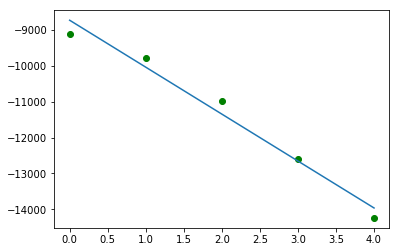

gradient ratio  = [     0.              0.          -9111.48815918  -9785.26196289
 -10985.78564453 -12609.28027344 -14239.16210938]


In [8]:
alphadata = obj[:]
# plt.semilogy(obj[0][2:], 'r-', label='no regularisation')
# plt.semilogy(obj[1][2:], 'g-', label='alpha=1.')
# plt.show()

print (alphadata[0])
DF0 = ( alphadata[0][-1] - alphadata[0][2] )
DF1  = ( alphadata[1][-1] - alphadata[1][2])
#DF50  = ( alphadata[2][-1] - alphadata[2][2])
beta = (DF1 / DF0 )-1
print ("beta = {} \nalpha = {}".format(beta, abs(1/beta)))
#beta = (DF50 / DF0 )-1
#print ("beta = {} \nalpha = {}".format(beta, abs(1/beta)))


print (alphadata[0] , alphadata[1])
# delta is the difference between the objective function with regularisation (alpha=1.) and no regularisation
delta =  numpy.asarray(alphadata[1]) - numpy.asarray(alphadata[0])
x = [i for i in range(len(delta[2:]))]
onedfit = numpy.polyfit([i for i in range(len(delta[2:]))], delta[2:],1)
fit_fn = numpy.poly1d(onedfit)
print (fit_fn)




plt.plot(delta[2:], 'go', label='alpha=1.')
plt.plot(x, fit_fn(x))
plt.show()

d_noreg = alphadata[0][-1] - alphadata[0][0]
d_reg = delta[-1] - delta[0]

beta = d_noreg / d_reg
print ("gradient ratio  = {}".format(delta))

In [9]:
fit_fn[0]

-8730.322387695312

In [11]:
# sliceno = 10
# plt.subplot(1,2,1)
# plt.imshow(algo.get_output().as_array()[sliceno])
# plt.title('{} iter {}'.format(algo.__class__.__name__, algo.iteration))
# plt.subplot(1,2,2)
# plt.plot(algo.get_output().as_array()[sliceno][50])
# plt.show()
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy

def display_slice(container, direction, title, cmap, minmax):
    
        
    def get_slice_3D(x):
        
        if direction == 0:
            img = container[x]
        elif direction == 1:
            img = container[:,x,:]
        elif direction == 2:
            img = container[:,:,x]
        
        fig = plt.figure()
        gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=(1,.05))
        # image
        ax = fig.add_subplot(gs[0, 0])
        aximg = ax.imshow(img, cmap=cmap)
        aximg.set_clim(minmax)
        ax.set_title(title + " {}".format(x))
        # colorbar
        ax = fig.add_subplot(gs[0, 1])
        plt.colorbar(aximg, cax=ax)
        plt.tight_layout()
        plt.show(fig)
        
    return get_slice_3D
    
def islicer(data, direction, title="", cmap='viridis', minmax=None):
    '''Creates an interactive integer slider that slices a 3D volume along direction
    
    :param data: DataContainer or numpy array
    :param direction: slice direction, int, should be 0,1,2 or the axis label
    :param title: optional title for the display
    '''
    
    if hasattr(data, "as_array"):
        container = data.as_array()
        if not isinstance (direction, int):
            if direction in data.dimension_labels.values():
                direction = data.get_dimension_axis(direction)
    elif isinstance (data, numpy.ndarray):
        container = data
        
    
    slider = widgets.IntSlider(min=0, max=data.shape[direction]-1, step=1, 
                             value=0, continuous_update=False)

    if minmax is None:
        amax = container.max()
        amin = container.min()
    else:
        amin = min(minmax)
        amax = max(minmax)
    
    interact(display_slice(container, 
                           direction, 
                           title=title, 
                           cmap=cmap, 
                           minmax=(amin, amax)),
             x=slider);
    return slider
    

def link_islicer(*args):
    '''links islicers IntSlider widgets'''
    linked = [(widg, 'value') for widg in args]
    # link pair-wise
    pairs = [(linked[i+1],linked[i]) for i in range(len(linked)-1)]
    for pair in pairs:
        widgets.link(*pair)
    
islicer(algo.get_output().as_array(), 1, "PDHG iter {}".format(algo.iteration), cmap='viridis')


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBjb250aW51b3VzX3VwZGF0ZT1GYWxzZSwgZGVzY3JpcHRpb249dSd4JywgbWF4PTEyNyksIE91dHB1dCgpKSwgX2RvbV/igKY=


IntSlider(value=0, continuous_update=False, description=u'x', max=127)

In [12]:
alphas = [0, 50.]
gs = [IndicatorBox(lower=0.), FGP_TV(alpha, 500, 1e-7, 0, 1, 0, 'gpu' )]
for alpha, g in zip(alphas, gs):
    print (alpha, g)

0 <ccpi.optimisation.functions.IndicatorBox.IndicatorBox object at 0x7f5d62047310>
50.0 <ccpi.plugins.regularisers.FGP_TV object at 0x7f5d62047c90>


In [13]:
# reset algo and run 500 iterations
# it should take 86.107 s/iter * 500 iter / 3600 s/h = 11.9 h
alphas = [0, 50.]
gs = [IndicatorBox(lower=0.), FGP_TV(alpha, 500, 1e-7, 0, 1, 0, 'gpu' )]
for alpha, g in zip(alphas, gs):
    algo = PDHG(f = fidelity, g = g, operator = operator, tau = tau, sigma = sigma)
    algo.max_iteration = 500
    algo.update_objective_interval = 10

    if False:
        run = 10
        for i in range(algo.max_iteration / run):
            algo.run(run)
            # saves to os.getcwd()
            #print (os.getcwd())
            fname = os.path.join(os.getcwd(),"PDHG_FGP_alpha{}_iter_{}".format(alpha,algo.iteration))
            algo.get_output().write(fname)
    else:
        def save_output(iteration,obj,x):
            alpha = 0
            fname = os.path.join(os.getcwd(),"PDHG_FGP_alpha{}_iter_{}".format(alpha,iteration))
            x.write(fname)

        algo.run(500,callback=save_output,verbose=True)

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          5.73073e+07
       10        500        37.736          2.65575e+07
       20        500        38.310          1.60834e+07
       30        500        38.396          1.54476e+07
       40        500        38.305          1.52408e+07
       50        500        39.241          1.51404e+07
       60        500        38.185          1.50810e+07
       70        500        38.481          1.50410e+07
       80        500        39.281          1.50117e+07
       90        500        39.354          1.49891e+07
      100        500        38.450          1.49708e+07
      110        500        38.962          1.49556e+07
      120        500        38.024          1.49428e+07
      130        500        37.695          1.49316e+07
      140        500        37.548          1.49218e+07
      150       

In [ ]:
fname = os.path.join(os.getcwd(),"PDHG_FGP_alpha{}_iter_{}".format(alpha,algo.iteration))
print (os.getcwd(), alpha, fname)
algo.get_output().write(fname)

In [ ]:
from ccpi.io import NEXUSReader
fname = os.path.join(os.getcwd(),"PDHG_FGP_alpha{}_iter_{}".format(alpha,100))
read = NEXUSReader()
read.set_up(nexus_file=fname)
read.load_data()

In [ ]:


s1 = islicer(algo.get_output().as_array(), 0, "PDHG iter {}".format(algo.iteration))
s0 = islicer(solution_4.as_array(), 0, "PDHG iter {}".format(4))

link_islicer(s1,s0)


In [ ]:
# saves to os.getcwd()
#print (os.getcwd())


algo.get_output().write("PDHG_FGP_alpha{}_iter_{}".format(alpha,algo.iteration))